In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
from transformers import AutoTokenizer
import pandas as pd
import seaborn as sns
from datasets import Dataset
from os.path import join as oj
import pickle as pkl
import os
import analyze_utils
import dvu
dvu.set_style()
cols_output = ['final_answer_found',
               'final_model_queries', 'final_num_suffixes_checked']

In [12]:
from typing import Dict
import pickle

# load suffix stuff
suffix_results = pickle.load(open('../results/prompt_gen/results_suffix_math.pkl', 'rb'))
SUFFIX_LEGEND_REMAP = {
    'Single-query': 'Suffix, single-output decoding',
    'Avg suffix': 'Suffix, average-output decoding',
}
suffix_results['legend'] = suffix_results['use_single_query'].map(
            SUFFIX_LEGEND_REMAP) + ' (' + suffix_results['n_shots'].astype(str) + '-Ex.)'
suffix_results['do_reranking'] = False
suffix_results['reciprocal_rank'] = suffix_results['final_answer_pos_initial_token'].map(lambda n: 1/(n+1))

# import prefix stuff
prefix_results = pickle.load(open('/home/jxm3/random/interpretable-autoprompting/results/prefix/math/r.pkl', 'rb'))
prefix_results['single_query'] = (prefix_results['max_num_samples'] == 1)
# prefix_results = analyze_utils.load_results_and_cache_prefix_json('/home/chansingh/mntv1/prefix_math_jack_actually_math', save_file='r.pkl')
# prefix_results = pickle.load(open('/home/jxm3/random/interpretable-autoprompting/results/intermediate_results_from_chandan_3/math/r.pkl', 'rb'))

def make_legend__prefix(table_row: Dict) -> str:
    single_query_str = {
        0: 'average',
        1: 'single'
    }[table_row['single_query']]
    rerank_str = {
        0: '',
        1: ' with reranking'
    }[table_row['do_reranking']]
    
    return 'Prefix, ' + single_query_str + '-output' + rerank_str + f' ({table_row["n_shots"]}-Ex.)'


prefix_results['legend'] = prefix_results.apply(make_legend__prefix, axis=1)
prefix_results = prefix_results.rename(columns={'single_query': 'use_single_query'})

In [13]:
def replace_max_rank(num: int, max_val: int = 10_000) -> int:
    if (num > max_val) or (pd.isna(num)):
        return max_val
    return num
    
prefix_results['final_answer_pos_initial_token'] = prefix_results['final_answer_pos_initial_token'].map(replace_max_rank)
prefix_results = analyze_utils.postprocess_results(prefix_results)
prefix_results['reciprocal_rank'] = prefix_results['final_answer_pos_initial_token'].map(lambda n: 1/(n+1))

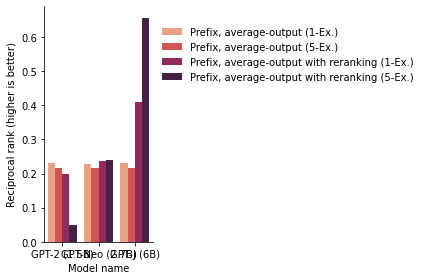

In [14]:
# metric_key = 'final_answer_pos_initial_token'
# metric_key = f'Recall @ {5} suffixes'
metric_key = 'reciprocal_rank'
tab = (
    (prefix_results
        # (mean over templates, task_name)
        .groupby(['checkpoint', 'n_shots', 'do_reranking', 'use_single_query', 'legend'])[[metric_key]]
        .mean()
        .reset_index()
    )
)
analyze_utils.plot_tab(tab, metric_key=metric_key, title='ANLI datasets', add_legend=False)

In [15]:
r = pd.concat((prefix_results, suffix_results), axis=0)

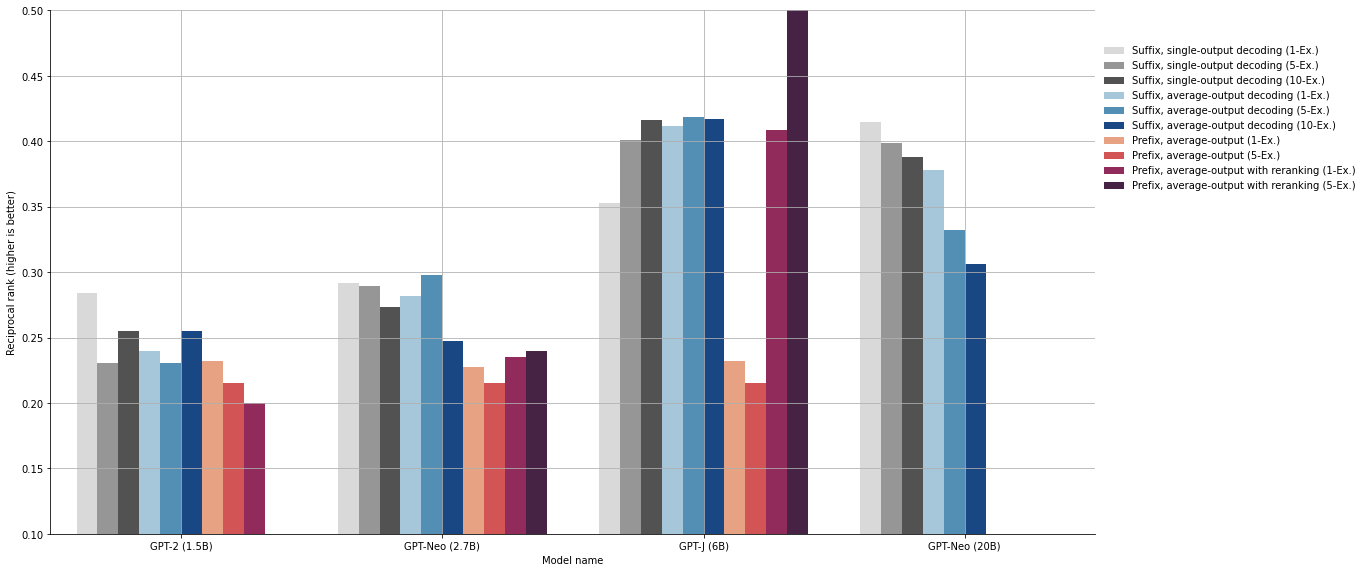

In [16]:
for metric_key in [
                 'reciprocal_rank',
                #  'final_answer_pos_initial_token',
                #  f'Recall @ {3} suffixes',
                #    f'Recall @ {10} suffixes', 
                #    f'Recall @ {100} suffixes',
                   ]:
    plt.figure(figsize=(19, 8))
    # plt.figure(figsize=(10, 3.5))
    tab = ((r
            # (mean over templates, task_name)
            .groupby(['checkpoint', 'n_shots', 'do_reranking', 'use_single_query', 'legend'])[[metric_key]]
            .mean()
            .reset_index()
        )
    )
    analyze_utils.plot_tab(tab, metric_key=metric_key, title='Math datasets', add_legend=False)
    plt.grid()
    plt.ylim((0.1, 0.5))
    if metric_key == 'reciprocal_rank':
        plt.savefig('../results/prompt_gen/joint_math_barplot.pdf', bbox_inches='tight')
        tab.to_pickle(f'../results/prompt_gen/tab_joint_math_{metric_key}.pkl')
    # plt.legend('', frameon=False)
    plt.show()

In [17]:
list(sns.color_palette("rocket", n_colors=4).as_hex())

['#4c1d4b', '#a11a5b', '#e83f3f', '#f69c73']

In [18]:
list(sns.color_palette("mako", n_colors=8).as_hex())[4:9]

['#348ba6', '#38aaac', '#55caad', '#a1dfb9']

In [19]:
prefix_results.groupby(['checkpoint', 'n_shots']).count()

index  batch_size  max_dset_size  seed  \
checkpoint              n_shots                                           
EleutherAI/gpt-j-6B     1         2560        5120           5120  5120   
                        5         1280        5120           5120  5120   
EleutherAI/gpt-neo-2.7B 1         2560        5120           5120  5120   
                        5         1280        5120           5120  5120   
gpt2-xl                 1         2560        5120           5120  5120   
                        5         2432        6272           6272  6272   

                                 n_epochs  max_digit  \
checkpoint              n_shots                        
EleutherAI/gpt-j-6B     1            5120       5120   
                        5            5120       5120   
EleutherAI/gpt-neo-2.7B 1            5120       5120   
                        5            5120       5120   
gpt2-xl                 1            5120       5120   
                        5            6272       6272   

                                 template_num_init_string  \
checkpoint              n_shots                             
EleutherAI/gpt-j-6B     1                            5120   
                        5                            5120   
EleutherAI/gpt-neo-2.7B 1                            5120   
                        5                            5120   
gpt2-xl                 1                            5120   
                        5                            6272   

                                 template_num_task_phrasing  save_dir  \
checkpoint              n_shots                                         
EleutherAI/gpt-j-6B     1                              5120      5120   
                        5                              5120      5120   
EleutherAI/gpt-neo-2.7B 1                              5120      5120   
                        5                              5120      5120   
gpt2-xl                 1                              5120      5120   
                        5                              6272      6272   

                                 epoch_save_interval  ...  \
checkpoint              n_shots                       ...   
EleutherAI/gpt-j-6B     1                       5120  ...   
                        5                       5120  ...   
EleutherAI/gpt-neo-2.7B 1                       5120  ...   
                        5                       5120  ...   
gpt2-xl                 1                       5120  ...   
                        5                       6272  ...   

                                 Recall @ 25 suffixes  Recall @ 30 suffixes  \
checkpoint              n_shots                                               
EleutherAI/gpt-j-6B     1                        5120                  5120   
                        5                        5120                  5120   
EleutherAI/gpt-neo-2.7B 1                        5120                  5120   
                        5                        5120                  5120   
gpt2-xl                 1                        5120                  5120   
                        5                        6272                  6272   

                                 Recall @ 40 suffixes  Recall @ 50 suffixes  \
checkpoint              n_shots                                               
EleutherAI/gpt-j-6B     1                        5120                  5120   
                        5                        5120                  5120   
EleutherAI/gpt-neo-2.7B 1                        5120                  5120   
                        5                        5120                  5120   
gpt2-xl                 1                        5120                  5120   
                        5                        6272                  6272   

                                 Recall @ 75 suffixes  Recall @ 100 suffixes  \
checkpoint              n_shots                                           

### Plot the best model

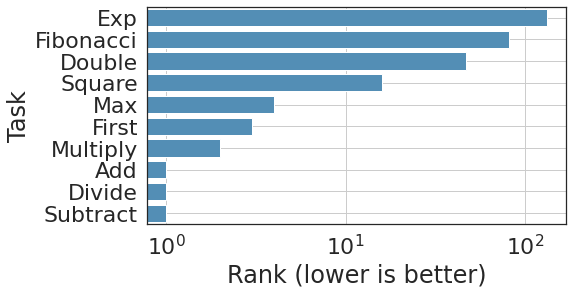

In [20]:
r['rank'] = r['final_answer_pos_initial_token'] + 1

def plot_model(legend_name: str):
    sns.set(style="white", font_scale=2)
    plt.figure(figsize=(7.5, 4))
    model_results = (
        r[(r['legend'] == legend_name) & (r['checkpoint'] == 'EleutherAI/gpt-j-6B')].reset_index()
            .sort_values(by='rank', ascending=False)
    )

    sns.barplot(data=model_results, y=model_results['task_name'].map(lambda x: x.split('_')[0].capitalize()), x='rank', color=analyze_utils.COLORS[legend_name]) 
    plt.grid()
    plt.xticks([1, 10, 100], labels=['1', '10', '100'])
    plt.gca().set_xscale('log')
    plt.xlabel('Rank (lower is better)')
    plt.ylabel('Task')
    
    # sns.barplot(data=model_results, y='task_name', x='rank', color=analyze_utils.COLORS[legend_name])
    # plt.gca().set_xscale('log')
    # plt.xlabel('Rank')
    # plt.ylabel('Task')
    
    
# plot_model(legend_name='Prefix, average-output (1-Ex.)')
plot_model(legend_name='Suffix, average-output decoding (5-Ex.)')
plt.savefig('../results/prompt_gen/best_rank_math.pdf', bbox_inches='tight')
# plot_model(legend_name='Suffix, average-output decoding (10-Ex.)')

In [21]:
r[r['legend'] == 'Suffix, average-output decoding (5-Ex.)'].reset_index()['task_name'].value_counts()

fibonacci_one    4
square_one       4
double_one       4
exp_one          4
multiply_two     4
max_two          4
add_two          4
divide_two       4
first_two        4
subtract_two     4
Name: task_name, dtype: int64